In [116]:
!pip install gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Flatten
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [26]:
train_df = pd.DataFrame(pd.read_excel("Downloads/train.xlsx"))
test_df = pd.DataFrame(pd.read_excel("Downloads/test.xlsx"))
train_df2 = pd.read_csv('Downloads/to_label.csv')

In [27]:
train_df=pd.concat([train_df,train_df2])

In [28]:
print('There are {} rows and {} columns in train'.format(train_df.shape[0],train_df.shape[1]))
print('There are {} rows and {} columns in test'.format(test_df.shape[0],test_df.shape[1]))
train_df.info()
train_df.isnull().sum()

There are 401 rows and 6 columns in train
There are 86 rows and 7 columns in test
<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 187
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  401 non-null    int64  
 1   Datetime    401 non-null    object 
 2   Tweet Id    401 non-null    float64
 3   Text        401 non-null    object 
 4   Username    401 non-null    object 
 5   labels      401 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 21.9+ KB


Unnamed: 0    0
Datetime      0
Tweet Id      0
Text          0
Username      0
labels        0
dtype: int64

C:\Users\Achint Soni\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

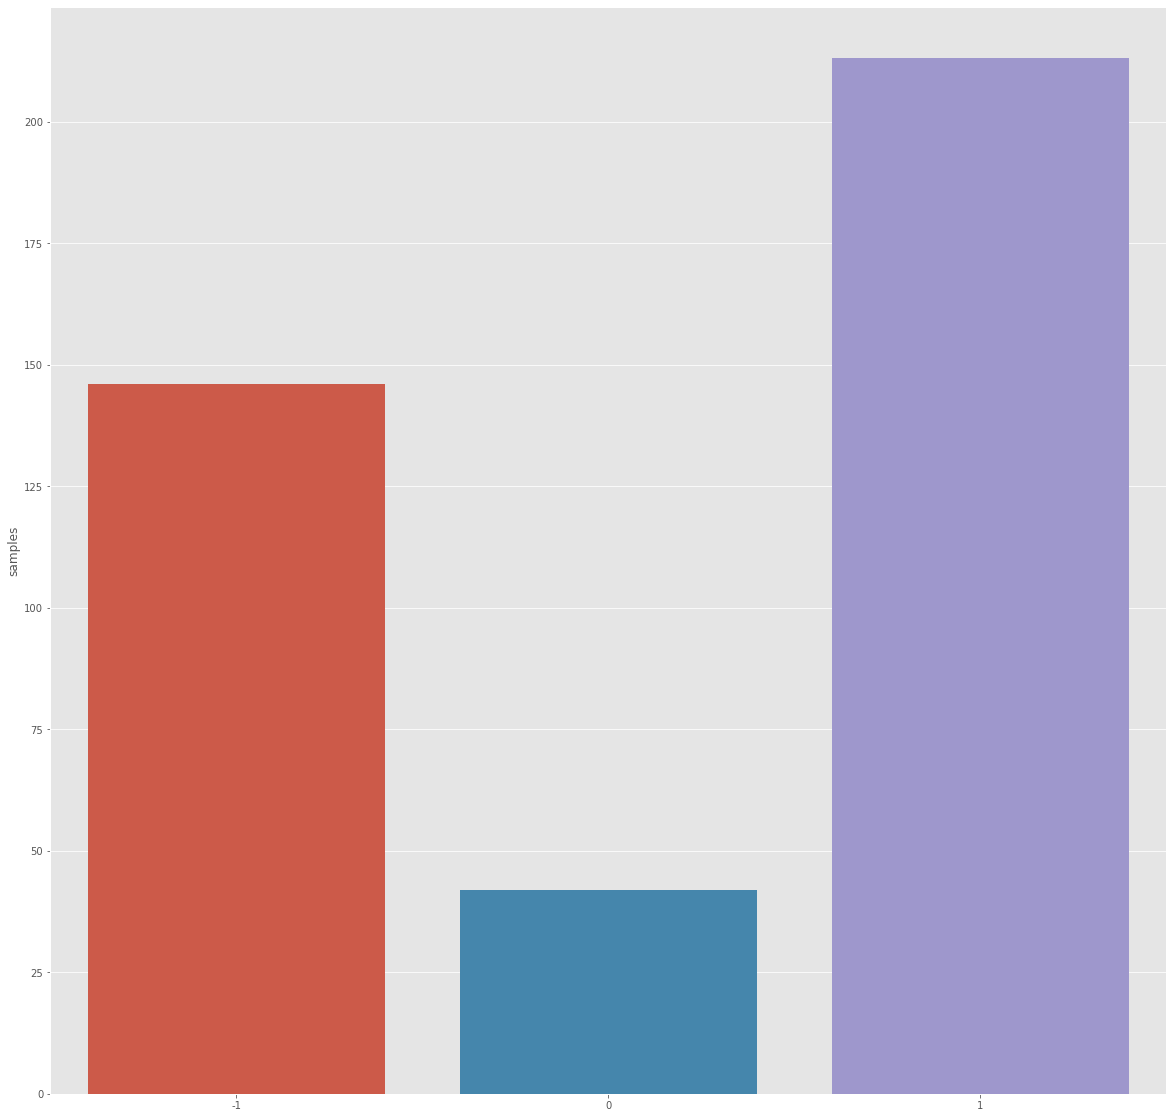

In [29]:
x=train_df.labels.value_counts()
plt.figure(figsize = (20,20))
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

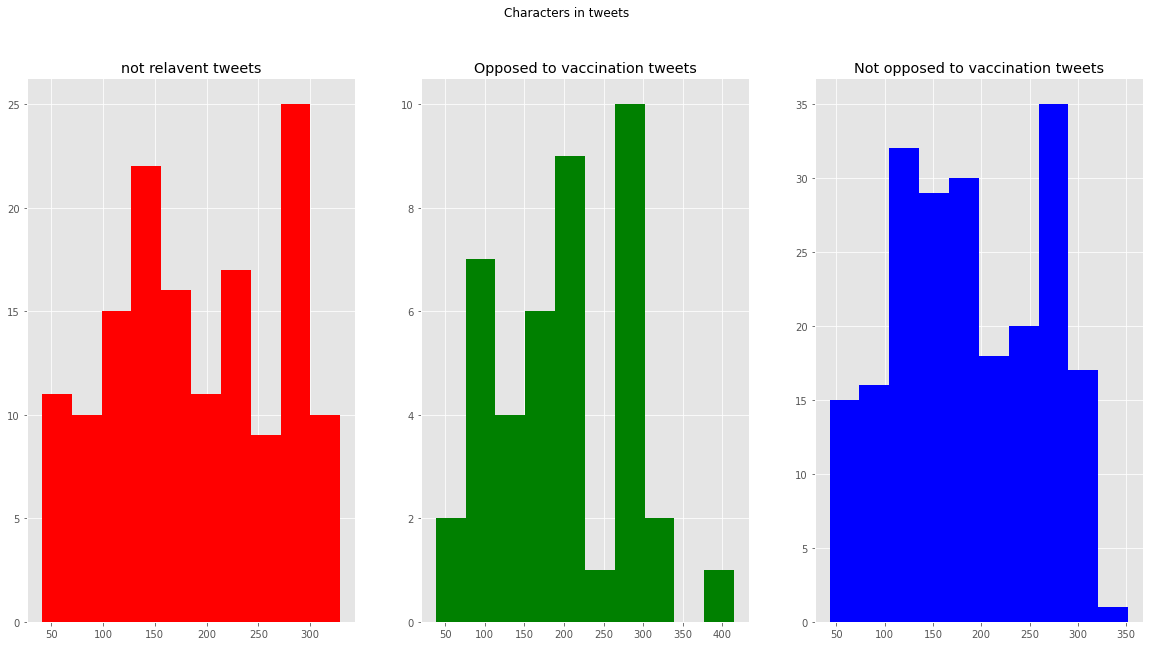

In [30]:
## Number of Characters in tweets ##
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
tweet_len=train_df[train_df['labels']==-1]['Text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('not relavent tweets')
tweet_len=train_df[train_df['labels']==0]['Text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Opposed to vaccination tweets')
tweet_len=train_df[train_df['labels']==1]['Text'].str.len()
ax3.hist(tweet_len,color='blue')
ax3.set_title('Not opposed to vaccination tweets')
fig.suptitle('Characters in tweets')
plt.show()

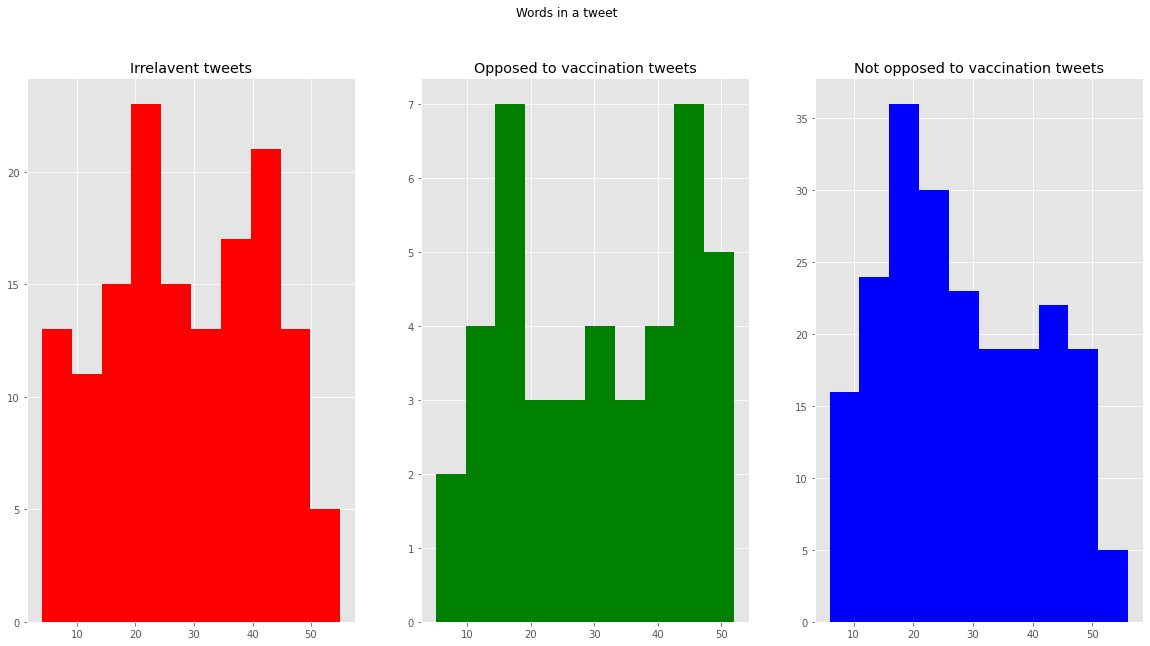

In [31]:
##Number of words in tweets ##
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
tweet_len=train_df[train_df['labels']==-1]['Text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Irrelavent tweets')
tweet_len=train_df[train_df['labels']==0]['Text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Opposed to vaccination tweets')
tweet_len=train_df[train_df['labels']==1]['Text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='blue')
ax3.set_title('Not opposed to vaccination tweets')
fig.suptitle('Words in a tweet')
plt.show()

C:\Users\Achint Soni\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Achint Soni\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Achint Soni\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

Text(0.5, 0.98, 'Average word length in each tweet')

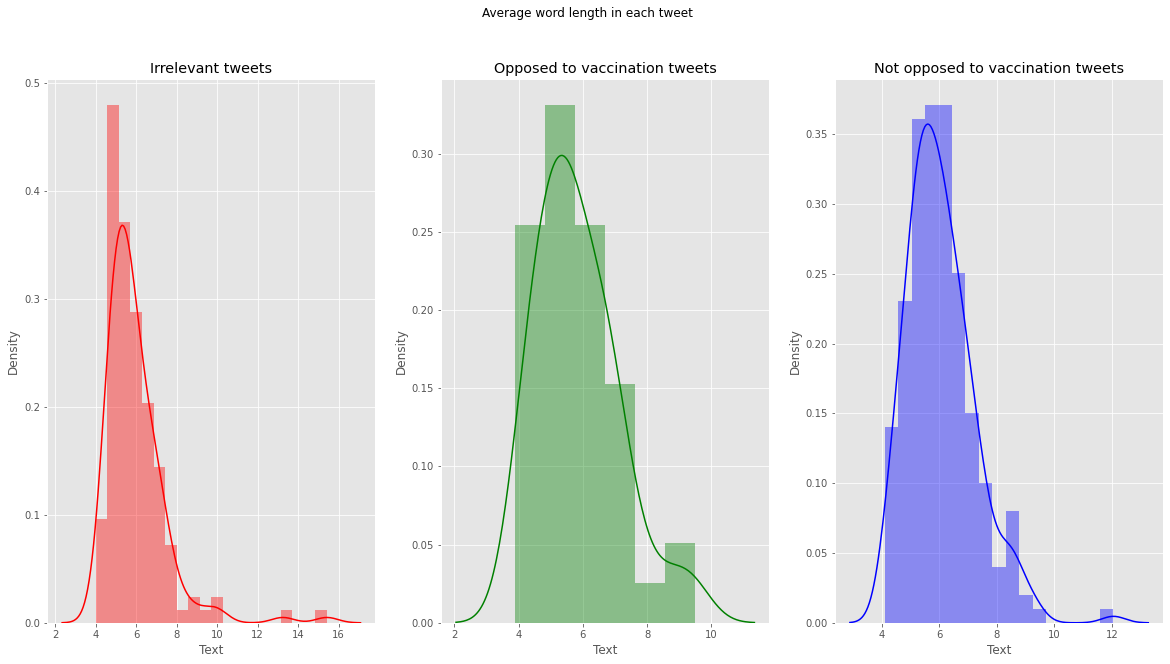

In [32]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
word=train_df[train_df['labels']==-1]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Irrelevant tweets')
word=train_df[train_df['labels']==0]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Opposed to vaccination tweets')
word=train_df[train_df['labels']==1]['Text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='blue')
ax3.set_title('Not opposed to vaccination tweets')
fig.suptitle('Average word length in each tweet')


In [33]:
def create_corpus(labels):
    corpus=[]
    
    for x in train_df[train_df['labels']==labels]['Text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [34]:
## Analyzing common stopwords in tweets of class -1
corpus=create_corpus(-1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 


<BarContainer object of 10 artists>

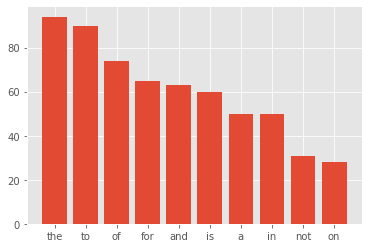

In [35]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

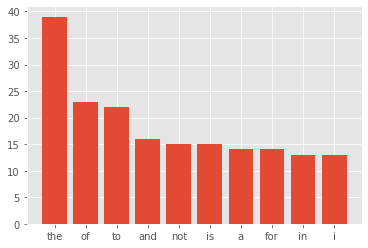

In [36]:
## Now analyzig common stop words in tweets of class 0
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

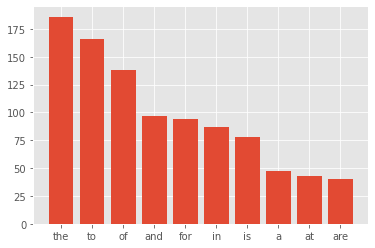

In [37]:
## Now analyzig common stop words in tweets of class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 14 artists>

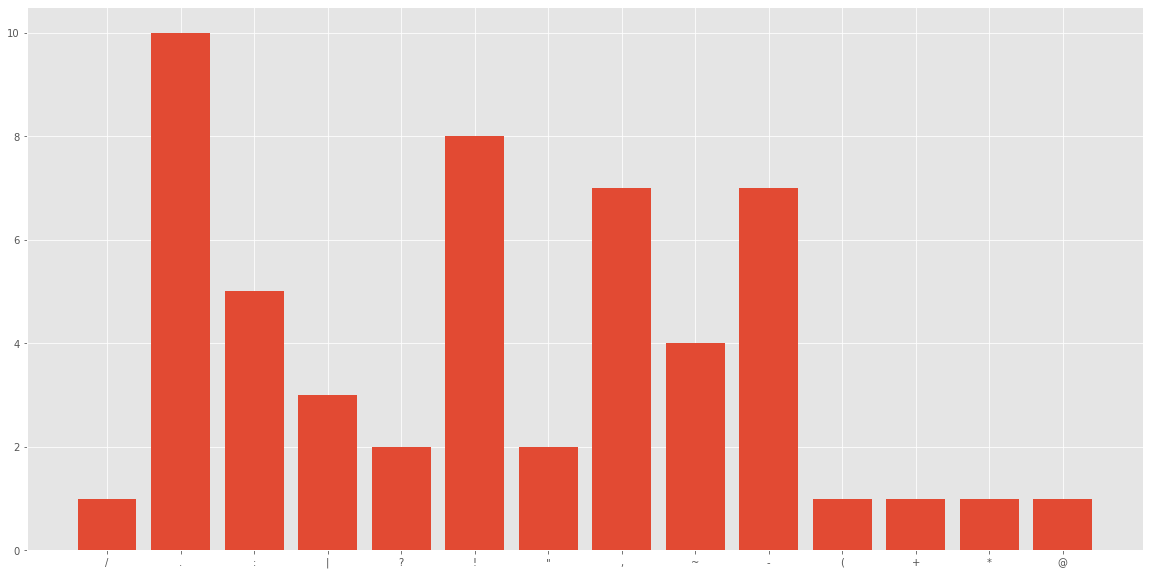

In [38]:
##Analyzing punctuations in tweets of class 1
plt.figure(figsize=(20,10))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 6 artists>

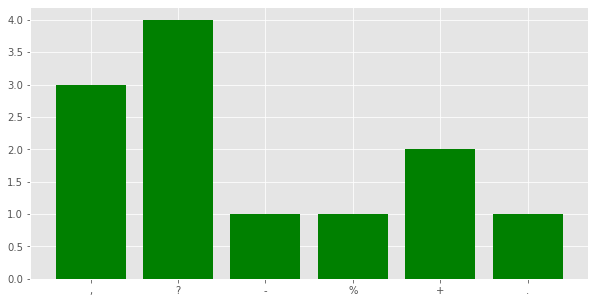

In [39]:
##Now for class 0
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')


<BarContainer object of 9 artists>

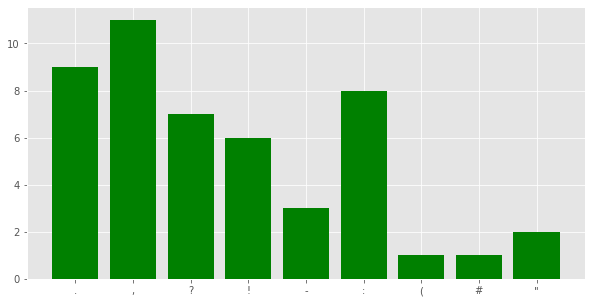

In [40]:
##Now for class -1
plt.figure(figsize=(10,5))
corpus=create_corpus(-1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')


In [41]:
## Common Words
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<AxesSubplot:>

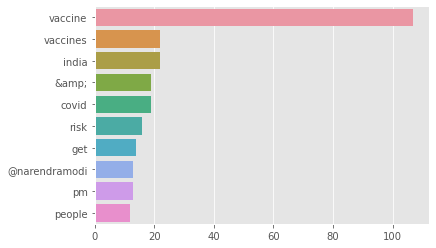

In [42]:
sns.barplot(x=y,y=x)

In [43]:
##This suggests that we need a lot of cleaning


In [44]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

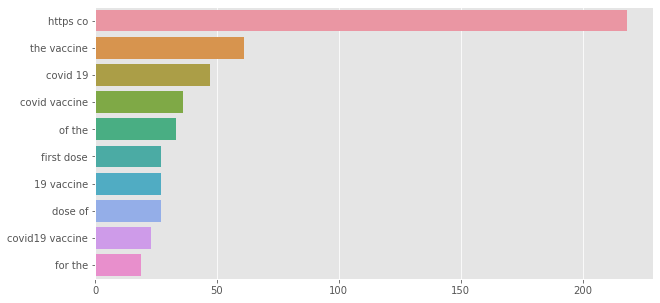

In [45]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train_df['Text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [46]:
df=pd.concat([train_df,test_df])
df.shape

(487, 7)

In [47]:
##Removing URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
df['Text']=df['Text'].apply(lambda x : remove_URL(x))

In [48]:
##Removing HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['Text']=df['Text'].apply(lambda x : remove_html(x))

In [49]:
##Removing Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Text']=df['Text'].apply(lambda x: remove_emoji(x))

In [50]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['Text']=df['Text'].apply(lambda x : remove_punct(x))

In [51]:
##SPELLING CORRECTION!

In [52]:
!pip install pyspellchecker

In [53]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
  

In [54]:
df['Text']=df['Text'].apply(lambda x : correct_spellings(x))

In [99]:
train_df.shape

(401, 6)

In [100]:
for i in range(401):
    train_df['labels'][i] = train_df['labels'][i] + 1

<ipython-input-100-296622164aec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'][i] = train_df['labels'][i] + 1
<ipython-input-100-296622164aec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'][i] = train_df['labels'][i] + 1
<ipython-input-100-296622164aec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'][i] = train_df['labels'][i] + 1
<ipython-input-100-296622164aec>:2: Setting

KeyError: 213

In [55]:
## Model Training

In [102]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Achint
[nltk_data]     Soni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [103]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['Text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [104]:
corpus=create_corpus(df)

100%|██████████████████████████████████████████████████████████████████████████████| 487/487 [00:00<00:00, 6760.73it/s]


In [105]:
embedding_dict={}
with open('Downloads/glove.6B.100d.txt/glove.6B.100d.txt','r',encoding = "utf8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [106]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [107]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))


Number of unique words: 2653


In [108]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec


100%|██████████████████████████████████████████████████████████████████████████| 2653/2653 [00:00<00:00, 443202.63it/s]


In [129]:
## Baseline Model
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(3, activation='softmax'))


optimzer=Adam(learning_rate=1e-3)

model.compile(loss='sparse_categorical_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [130]:
model.summary()
train_df.shape[1]

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           265400    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 307,835
Trainable params: 42,435
Non-trainable params: 265,400
_________________________________________________________________


6

In [131]:
train=tweet_pad[:train_df.shape[0]]
test=tweet_pad[train_df.shape[0]:]

In [132]:
X_train,X_test,y_train,y_test=train_test_split(train,train_df['labels'].values,test_size=0.15)
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (340, 50)
Shape of Validation  (61, 50)


In [133]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
85/85 - 3s - loss: 1.0107 - accuracy: 0.5118 - val_loss: 0.9068 - val_accuracy: 0.6066
Epoch 2/15
85/85 - 1s - loss: 0.9528 - accuracy: 0.5176 - val_loss: 0.9097 - val_accuracy: 0.6066
Epoch 3/15
85/85 - 1s - loss: 0.9507 - accuracy: 0.5147 - val_loss: 0.9272 - val_accuracy: 0.6066
Epoch 4/15
85/85 - 1s - loss: 0.9325 - accuracy: 0.5206 - val_loss: 0.9266 - val_accuracy: 0.6066
Epoch 5/15
85/85 - 1s - loss: 0.9283 - accuracy: 0.5029 - val_loss: 0.9239 - val_accuracy: 0.6230
Epoch 6/15
85/85 - 1s - loss: 0.8896 - accuracy: 0.5382 - val_loss: 0.9686 - val_accuracy: 0.6557
Epoch 7/15
85/85 - 1s - loss: 0.8954 - accuracy: 0.5471 - val_loss: 0.9270 - val_accuracy: 0.6557
Epoch 8/15
85/85 - 1s - loss: 0.8630 - accuracy: 0.5735 - val_loss: 0.9552 - val_accuracy: 0.5902
Epoch 9/15
85/85 - 1s - loss: 0.8797 - accuracy: 0.5647 - val_loss: 0.9695 - val_accuracy: 0.5902
Epoch 10/15
85/85 - 2s - loss: 0.8551 - accuracy: 0.5588 - val_loss: 0.8909 - val_accuracy: 0.5574
Epoch 11/15
85/85 -